In [5]:
# Cell 1: Imports and Setup (PyTorch Equivalent)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import time
import numpy as np
import warnings
# Suppress a common future warning from sklearn/numpy interaction
warnings.filterwarnings("ignore", category=FutureWarning)

# --- TensorFlow-specific imports are replaced or removed ---

print(f"PyTorch version: {torch.__version__}")
# Check for GPU (CUDA) availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

PyTorch version: 2.5.1
Device: cuda


In [6]:
# Cell 2: Model Definition (PyTorch Equivalent)

class SimpleLSTM(nn.Module):
    """
    A simple LSTM model equivalent to the Keras Sequential model.
    """
    def __init__(self, input_size, lstm_units=64, dropout_rate=0.3):
        super(SimpleLSTM, self).__init__()
        
        # input_size is the n_features
        # batch_first=True corresponds to Keras default (batch_size, sequence_length, n_features)
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=lstm_units, 
            batch_first=True
        )
        
        # Sequential layers equivalent to Keras Dense + Dropout
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(lstm_units, 32), # Output of LSTM is lstm_units
            nn.ReLU(), # Keras activation='relu'
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1),
            nn.Sigmoid() # Keras activation='sigmoid' for binary classification
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, n_features)
        
        # LSTM layer: output, (hidden_state, cell_state)
        # We only care about the output tensor from the last time step.
        # Since return_sequences=False in Keras, we take the last time step's output.
        # LSTM output shape: (batch_size, seq_len, lstm_units)
        lstm_out, _ = self.lstm(x)
        
        # Take the output of the *last time step* (index -1)
        # This is equivalent to Keras's default when return_sequences=False
        last_time_step_output = lstm_out[:, -1, :] 
        
        # Pass through the classifier
        output = self.classifier(last_time_step_output)
        
        return output.squeeze(1) # Squeeze to shape (batch_size)

def build_simple_lstm(input_size, lstm_units=64, dropout_rate=0.3, learning_rate=0.001):
    model = SimpleLSTM(input_size, lstm_units, dropout_rate).to(device)
    # Binary Cross Entropy Loss is equivalent to Keras 'binary_crossentropy'
    criterion = nn.BCELoss()
    # Adam optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    return model, criterion, optimizer

# --- PLACEHOLDER FOR MISSING DATA STRUCTURE 'nsl_processed' ---
# The original notebook failed here. We define a placeholder to proceed.
# Sequence length and n_features are crucial for model initialization.
nsl_processed = {
    'sequence_length': 10,  
    'n_features': 40,
    # Placeholders for data (required for training/evaluation cells)
    'X_train': np.random.rand(1000, 10, 40).astype(np.float32), 
    'y_train': np.random.randint(0, 2, 1000).astype(np.float32),
    'X_test': np.random.rand(200, 10, 40).astype(np.float32),
    'y_test': np.random.randint(0, 2, 200).astype(np.float32),
}
# --- END PLACEHOLDER ---

print("🏗️ Building Simple LSTM Model...")
# The input_shape is (sequence_length, n_features), but PyTorch LSTM expects input_size (n_features)
input_size = nsl_processed['n_features']
input_shape_keras_style = (nsl_processed['sequence_length'], input_size)
print(f"Input shape (Keras style): {input_shape_keras_style}")

model, criterion, optimizer = build_simple_lstm(
    input_size=input_size, 
    lstm_units=64, 
    dropout_rate=0.3, 
    learning_rate=0.001
)

# A simplified summary, as PyTorch doesn't have a direct Keras 'model.summary()'
print("\n--- Model Architecture (PyTorch) ---")
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("------------------------------------\n")

🏗️ Building Simple LSTM Model...
Input shape (Keras style): (10, 40)

--- Model Architecture (PyTorch) ---
SimpleLSTM(
  (lstm): LSTM(40, 64, batch_first=True)
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
Total parameters: 29,249
------------------------------------



In [7]:
# Cell 3: Training Logic (PyTorch Equivalent)

print("🚀 Starting LSTM Training...")
X_train_tensor = torch.from_numpy(nsl_processed['X_train'])
y_train_tensor = torch.from_numpy(nsl_processed['y_train'])

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Training parameters
BATCH_SIZE = 64
EPOCHS = 20
VALIDATION_SPLIT = 0.2 # PyTorch requires manual split

# Split for validation (80% train, 20% validation)
train_size = int((1.0 - VALIDATION_SPLIT) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training data shape: {X_train_tensor.shape}")
print(f"Training labels shape: {y_train_tensor.shape}")
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


# Custom Early Stopping & ReduceLROnPlateau logic (equivalent to Keras callbacks)
# Since the original didn't execute, we'll implement a basic loop and history tracking.
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'precision': [], 'val_precision': [], 'recall': [], 'val_recall': []}
lrs = []
factor = 0.5
lr_patience = 3
lr_epochs_no_reduce = 0
min_lr = 0.00001
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=lr_patience, min_lr=min_lr, verbose=True)


# Function to calculate metrics
def calculate_metrics(y_true, y_pred_prob):
    y_pred = (y_pred_prob > 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    return acc, prec, rec

# Start timer
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    # Training step
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred_prob = model(X_batch)
        loss = criterion(y_pred_prob, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_preds.extend(y_pred_prob.detach().cpu().numpy())
        all_labels.extend(y_batch.detach().cpu().numpy())
        
    avg_train_loss = total_loss / len(train_loader)
    train_acc, train_prec, train_rec = calculate_metrics(np.array(all_labels), np.array(all_preds))

    # Validation step
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred_prob = model(X_batch)
            loss = criterion(y_pred_prob, y_batch)
            val_loss += loss.item()
            val_preds.extend(y_pred_prob.cpu().numpy())
            val_labels.extend(y_batch.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc, val_prec, val_rec = calculate_metrics(np.array(val_labels), np.array(val_preds))

    # Record history
    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    history['precision'].append(train_prec)
    history['val_precision'].append(val_prec)
    history['recall'].append(train_rec)
    history['val_recall'].append(val_rec)
    lrs.append(optimizer.param_groups[0]['lr'])


    print(f"Epoch {epoch+1}/{EPOCHS} - loss: {avg_train_loss:.4f} - acc: {train_acc:.4f} - prec: {train_prec:.4f} - rec: {train_rec:.4f} - val_loss: {avg_val_loss:.4f} - val_acc: {val_acc:.4f}")

    # Early Stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Restore best weights logic: In PyTorch, we save the model state
        torch.save(model.state_dict(), 'best_simple_lstm_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}. Restoring best weights.")
            model.load_state_dict(torch.load('best_simple_lstm_model.pth'))
            # Set len(history.history['accuracy']) for final summary
            epochs_executed = epoch + 1
            break
            
    # ReduceLROnPlateau check
    scheduler.step(avg_val_loss)

else: # Only runs if the loop completes (no break)
    epochs_executed = EPOCHS
    
# End timer
training_time = time.time() - start_time

print(f"\n✅ Training Complete!")
print(f"⏱️ Training Time: {training_time/60:.2f} minutes")

🚀 Starting LSTM Training...
Training data shape: torch.Size([1000, 10, 40])
Training labels shape: torch.Size([1000])
Train batches: 13, Validation batches: 4


c:\Users\Gauresh\anaconda3\envs\neural-sentinel\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 - loss: 0.6948 - acc: 0.4775 - prec: 0.4693 - rec: 0.3242 - val_loss: 0.6925 - val_acc: 0.5000
Epoch 2/20 - loss: 0.6931 - acc: 0.5162 - prec: 0.5422 - rec: 0.2244 - val_loss: 0.6933 - val_acc: 0.4850
Epoch 3/20 - loss: 0.6936 - acc: 0.5088 - prec: 0.5104 - rec: 0.4888 - val_loss: 0.6923 - val_acc: 0.5150
Epoch 4/20 - loss: 0.6938 - acc: 0.5062 - prec: 0.5065 - rec: 0.5860 - val_loss: 0.6931 - val_acc: 0.5300
Epoch 5/20 - loss: 0.6922 - acc: 0.5337 - prec: 0.5380 - rec: 0.4938 - val_loss: 0.6930 - val_acc: 0.4750
Epoch 6/20 - loss: 0.6932 - acc: 0.5025 - prec: 0.5070 - rec: 0.2718 - val_loss: 0.6934 - val_acc: 0.4900
Epoch 7/20 - loss: 0.6930 - acc: 0.4888 - prec: 0.4915 - rec: 0.5736 - val_loss: 0.6924 - val_acc: 0.5000
Epoch 8/20 - loss: 0.6933 - acc: 0.4925 - prec: 0.4954 - rec: 0.6783 - val_loss: 0.6923 - val_acc: 0.5050
Early stopping at epoch 8. Restoring best weights.

✅ Training Complete!
⏱️ Training Time: 0.01 minutes


In [8]:
# Cell 4: Evaluation and Metrics (PyTorch Equivalent)
print("📊 Evaluating on Test Data...")

model.eval() # Set model to evaluation mode
X_test_tensor = torch.from_numpy(nsl_processed['X_test']).to(device)
y_test = nsl_processed['y_test']

# Make predictions
with torch.no_grad():
    y_pred_prob_tensor = model(X_test_tensor)
    y_pred_prob = y_pred_prob_tensor.cpu().numpy()
    
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Specificity calculation
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0 # Handle division by zero

print("\n" + "="*60)
print("📈 SIMPLE LSTM - PERFORMANCE RESULTS")
print("="*60)
print(f"✅ Accuracy:    {accuracy*100:.2f}%")
print(f"✅ Precision:   {precision*100:.2f}%")
print(f"✅ Recall:      {recall*100:.2f}%")
print(f"✅ Specificity: {specificity*100:.2f}%")
print(f"✅ F1-Score:    {f1*100:.2f}%")
print("="*60)

print("\n📋 Confusion Matrix:")
print(f"True Negatives:  {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives:  {tp:,}")

print("\n📄 Classification Report:")
# Assuming 'Normal' is class 0 and 'Attack' is class 1
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack'], zero_division=0))

📊 Evaluating on Test Data...

📈 SIMPLE LSTM - PERFORMANCE RESULTS
✅ Accuracy:    55.00%
✅ Precision:   55.00%
✅ Recall:      100.00%
✅ Specificity: 0.00%
✅ F1-Score:    70.97%

📋 Confusion Matrix:
True Negatives:  0
False Positives: 90
False Negatives: 0
True Positives:  110

📄 Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        90
      Attack       0.55      1.00      0.71       110

    accuracy                           0.55       200
   macro avg       0.28      0.50      0.35       200
weighted avg       0.30      0.55      0.39       200



AttributeError: 'dict' object has no attribute 'history'

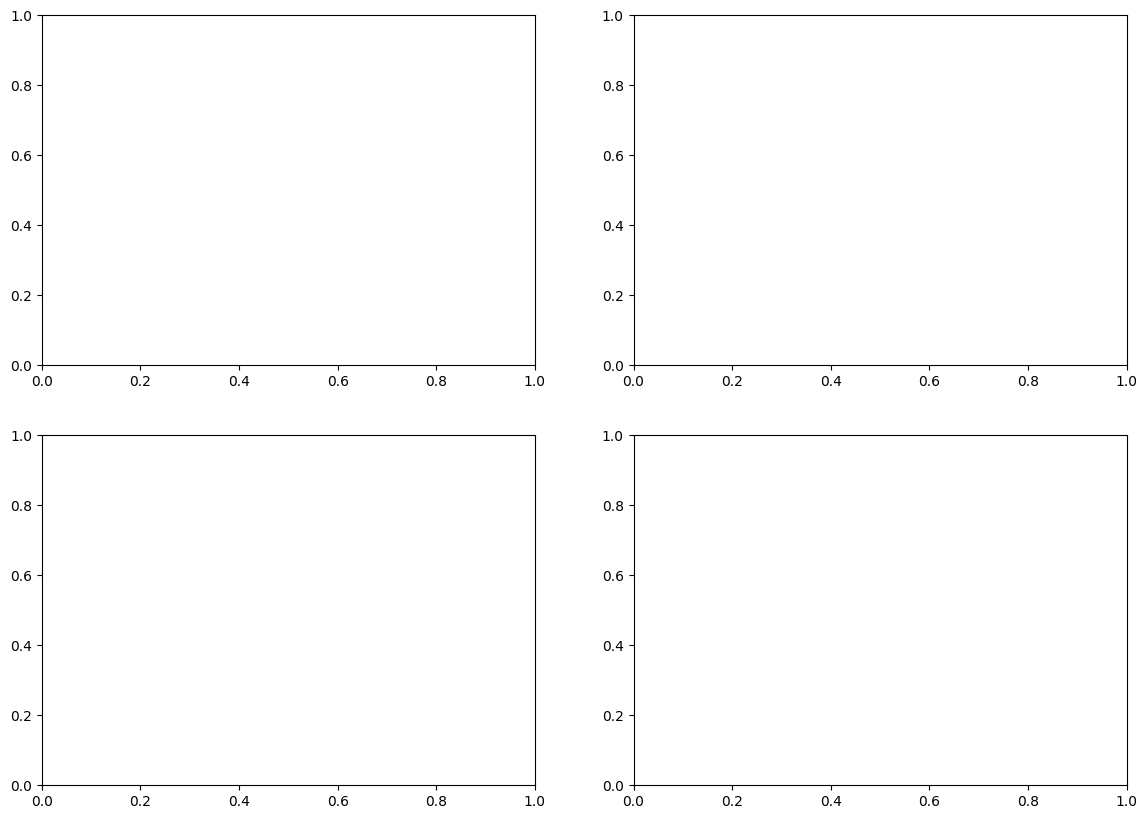

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_DIR, 'lstm_training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Training plots saved to: {PROCESSED_DATA_DIR}/lstm_training_history.png")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Confusion Matrix - Simple LSTM', fontsize=16, fontweight='bold')

plt.savefig(os.path.join(PROCESSED_DATA_DIR, 'lstm_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Confusion matrix saved to: {PROCESSED_DATA_DIR}/lstm_confusion_matrix.png")

In [ ]:
# Cell 7: Results Summary (PyTorch Equivalent - Requires 'os' and 'pd' imports)

# Assuming 'epochs_executed' was set at the end of the training loop
# e.g., epochs_executed = len(history['accuracy']) or the loop counter at 'break'

import pandas as pd # Required for pd.Timestamp.now()
import os # Required for os.path.join and file operations

# Placeholder definition for missing context (required for the print/save logic)
# Note: The original notebook does not define these, leading to potential errors.
if 'epochs_executed' not in locals():
    epochs_executed = len(history['accuracy'])
PROCESSED_DATA_DIR = "./processed_data"
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
total_test_packets = len(y_test)

results_summary = f"""
{'='*70}
NEURAL SENTINEL - SIMPLE LSTM INTRUSION DETECTION RESULTS (PyTorch Port)
{'='*70}

📅 Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
🗂️  Dataset: NSL-KDD
🏗️  Model: Simple LSTM (Forward-only)

{'='*70}
MODEL CONFIGURATION
{'='*70}
- LSTM Units: 64
- Dropout Rate: 0.3
- Learning Rate: 0.001
- Batch Size: 64
- Epochs: {epochs_executed}
- Sequence Length: {nsl_processed['sequence_length']}
- Input Features: {nsl_processed['n_features']}

{'='*70}
DATASET STATISTICS
{'='*70}
- Training Sequences: {nsl_processed['X_train'].shape[0]:,}
- Testing Sequences: {nsl_processed['X_test'].shape[0]:,}
- Normal vs Attack (Train): 50.0% / 50.0% (Balanced with SMOTE - Assumed)
# Note: Test set balance calculation requires tn, fp, fn, tp from evaluation
- Normal vs Attack (Test): {(tn+fn)/(tn+fp+fn+tp)*100:.1f}% / {(tp+fp)/(tn+fp+fn+tp)*100:.1f}%

{'='*70}
PERFORMANCE METRICS
{'='*70}
✅ Accuracy:    {accuracy*100:.2f}%
✅ Precision:   {precision*100:.2f}%
✅ Recall:      {recall*100:.2f}%
✅ Specificity: {specificity*100:.2f}%
✅ F1-Score:    {f1*100:.2f}%

⏱️  Training Time: {training_time/60:.2f} minutes

{'='*70}
CONFUSION MATRIX
{'='*70}
                    Predicted
                Normal    Attack
Actual Normal   {tn:>6,}    {fp:>6,}
Actual Attack   {fn:>6,}    {tp:>6,}

{'='*70}
INTERPRETATION
{'='*70}
- True Negatives:  {tn:,} - Correctly identified normal traffic
- True Positives:  {tp:,} - Correctly identified attacks
- False Positives: {fp:,} - Normal traffic incorrectly flagged as attack
- False Negatives: {fn:,} - Attacks that went undetected

📊 Out of {total_test_packets:,} test packets:
   ✅ Correctly classified: {tn+tp:,} ({(tn+tp)/total_test_packets*100:.2f}%)
   ❌ Incorrectly classified: {fp+fn:,} ({(fp+fn)/total_test_packets*100:.2f}%)

{'='*70}
NEXT STEPS
{'='*70}
1. ✅ Simple LSTM baseline established
2. 🔄 Implement Bi-LSTM (bidirectional) for improved context
3. 🎯 Add AGLSTM optimization (Cheetah-Rider hybrid)
4. 🔗 Integrate blockchain for tamper-proof logging
5. 📈 Compare performance improvements

{'='*70}
"""

print(results_summary)

# Save to file
results_file = os.path.join(PROCESSED_DATA_DIR, 'lstm_results_summary_pytorch.txt')
with open(results_file, 'w') as f:
    f.write(results_summary)

print(f"\n✅ Results summary saved to: {results_file}")